### SI 670 Final Project

# Classifying Yelp User Rating with Yelp User Reviews

#### Team: Machine Liers
#### Team members: Yuan Cheng, Xinyi Zhao, Meixin Yuan 


## Data Cleaning and Processing

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
review = []
with open ('yelp_academic_dataset_review.json', 'r') as inf:
    for line in inf:
        data=json.loads(line)
        review.append(data)

In [ ]:
review_id = []
user_id= []
business_id = []
stars = []
useful = []
funny = []
cool = []
text = []
date = []
for line in review:
    review_id.append(line['review_id'])
    user_id.append(line['user_id'])
    business_id.append(line['business_id'])
    stars.append(line['stars'])
    useful.append(line['useful'])
    funny.append(line['funny'])
    cool.append(line['cool'])
    text.append(line['text'])
    date.append(line['date'])
       

In [ ]:
df_review = pd.DataFrame({'review_id':review_id,'user_id':user_id, 'business_id':business_id, 'stars':stars, 'useful':useful, 'funny':funny,'cool':cool,'text':text,'date':date})

In [ ]:
business = []
with open ('yelp_academic_dataset_business.json', 'r') as inf:
    for line in inf:
        data=json.loads(line)
        business.append(data)

In [ ]:
business_id = []
name = []
address = []
city = []
state = []
postal_code = []
business_stars = []
review_count = []
is_open = []
attributes = []
categories = []
for line in business:
    business_id.append(line['business_id'])
    name.append(line['name'])
    address.append(line['address'])
    city.append(line['city'])
    state.append(line['state'])
    postal_code.append(line['postal_code'])
    business_stars.append(line['stars'])
    review_count.append(line['review_count'])
    is_open.append(line['is_open'])
    attributes.append(line['attributes'])
    categories.append(line['categories'])


In [ ]:
df_business = pd.DataFrame({'business_id':business_id,'name':name, 'address':address, 'city':city, 'state': state, 'postal_code':postal_code,'business_stars':business_stars, 'review_count':review_count,'is_open':is_open,'attributes':attributes,'categories':categories})      

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras import Sequential
from keras import models
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dropout, Dense, Embedding, Conv1D, MaxPooling1D, Bidirectional
from keras import layers
from keras.metrics import binary_accuracy
import tensorflow as tf
import numpy as np

In [ ]:
df_business['restaurant']=df_business.categories.str.contains('Restaurants')
restaurant = df_business[['business_id','name','state','is_open','attributes','restaurant']]
review_restaurant = df_review.merge(restaurant, on="business_id")

review_restaurant = review_restaurant[(review_restaurant['restaurant']==True)|(review_restaurant['is_open']==1)]

review_restaurant = review_restaurant.drop(columns=['user_id', 'date', 'restaurant', 'is_open'])
review_restaurant['is_good'] = np.where(review_restaurant['stars']>=4.0, 1, 0)

review_restaurant = review_restaurant[review_restaurant['state']=='PA']

#Convert the star column to a binary dataset, 3 stars or above will be positive otherwise, negative.
texts = review_restaurant['text'].tolist()
#print(review_restaurant_TX['stars'][index] for index in range(len(review_restaurant_TX['stars'])))
binstars = review_restaurant['is_good'].tolist()

In [ ]:
review_restaurant.to_csv(r'review_restaurant_PA.csv',index = True, header=True)

###  *Load the former dataset for future processing (instead of perform data cleaning everytime) *


In [ ]:
padata = pd.read_csv('review_restaurant_PA.csv')
review_restaurant=padata
texts = review_restaurant['text'].tolist()
binstars = review_restaurant['is_good'].tolist()

## Exploratory data analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
%matplotlib inline
from wordcloud.wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from PIL import Image

In [ ]:
review_restaurant.shape


(344253, 13)

In [ ]:
review_restaurant['Text length'] = review_restaurant['text'].apply(lambda x:len(x.split()))
review_restaurant.describe()

,Unnamed: 0,stars,useful,funny,cool,is_good,Text length
count,3.442530e+05,344253.000000,344253.000000,344253.000000,344253.000000,344253.000000,344253.000000
mean,3.936528e+06,3.706324,1.233177,0.368947,0.559156,0.775604,113.690399
std,2.343248e+06,1.428404,2.824600,1.616469,2.080602,0.417185,104.816490
min,3.240000e+03,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.890771e+06,3.000000,0.000000,0.000000,0.000000,1.000000,45.000000
50%,3.887088e+06,4.000000,0.000000,0.000000,0.000000,1.000000,82.000000
75%,5.988563e+06,5.000000,1.000000,0.000000,0.000000,1.000000,146.000000
max,8.020918e+06,5.000000,149.000000,258.000000,133.000000,1.000000,1004.000000


<AxesSubplot:xlabel='stars', ylabel='count'>

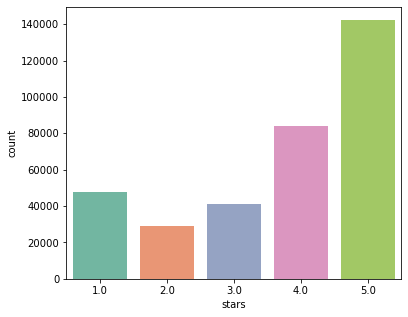

In [ ]:
plt.figure(figsize = (6,5))
sns.countplot('stars', data = review_restaurant, palette="Set2")

is_good
0    136.297065
1    107.149889
Name: Text length, dtype: float64

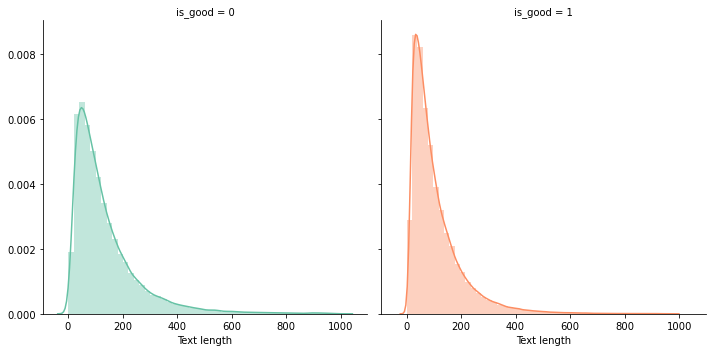

In [ ]:
len_rv = sns.FacetGrid(data = review_restaurant, col = 'is_good', hue = 'is_good', palette='Set2', size=5)
len_rv.map(sns.distplot, "Text length")
review_restaurant.groupby('is_good').mean()['Text length']

In [ ]:
good = review_restaurant[review_restaurant['is_good'] == 1]
bad = review_restaurant[review_restaurant['is_good'] == 0]
good_rv = good['text']
bad_rv= bad['text']
good_para = ' '.join(good_rv)
bad_para = ' '.join(bad_rv)

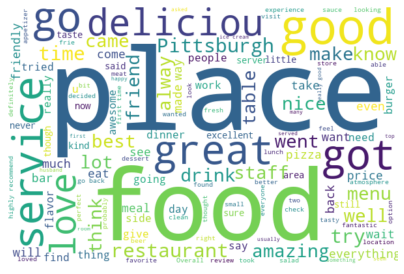

<Figure size 720x432 with 0 Axes>

In [ ]:
stopwords = set(STOPWORDS)
stopwords.add('one')
stopwords.add('order')
stopwords.add('ordered')

goodcloud = WordCloud(background_color="white", width = 300, height = 200, scale=2,max_words=1000, stopwords=stopwords).generate(good_para)
plt.figure(figsize = (7,10))
plt.imshow(goodcloud, interpolation="bilinear", cmap = plt.cm.autumn)
plt.axis('off')
plt.figure(figsize = (10,6))
plt.show()


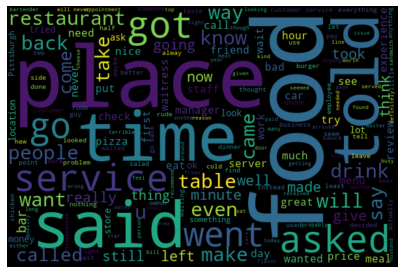

<Figure size 720x432 with 0 Axes>

In [ ]:
stopwords = set(STOPWORDS)
stopwords.add('one')
stopwords.add('good')
stopwords.add('order')
stopwords.add('ordered')

badcloud = WordCloud(background_color='black', width = 300, height = 200, scale=2,max_words=1000, stopwords=stopwords).generate(bad_para)
plt.figure(figsize = (7,10))
plt.imshow(wordcloud_good, interpolation="bilinear", cmap = plt.cm.autumn)
plt.axis('off')
plt.figure(figsize = (10,6))
plt.show()

In [ ]:
goodcloud.to_file('bad.png')
badcloud.to_file('good.png')

## Model Training 

### Baseline: Naive Bayes Classifier

In [ ]:
x=review_restaurant['text']
y=review_restaurant ['is_good']
from sklearn.feature_extraction.text import CountVectorizer
vectorizer  = CountVectorizer()
x = vectorizer.fit_transform(texts)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3, random_state =100)


from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train, y_train)
predictions = nb.predict(x_test)
predictions [0:5]

array([1, 1, 0, 1, 0], dtype=int64)

In [ ]:
trainsc=nb.score(x_train, y_train)
testsc=nb.score(x_test, y_test)
print ('The accuracy score of training dataset is:', trainsc)
print ('The accuracy score of test dataset is:', testsc)
from sklearn.metrics import mean_absolute_error
print("MAE:", mean_absolute_error(y_test, predictions))

The accuracy score of training dataset is: 0.8859102735945754
The accuracy score of test dataset is: 0.8780742863782486
MAE: 0.12192571362175142


### Deep Learning LSTM Networks (Model Two)

In [ ]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences, maxlen=100)
word_index = tokenizer.word_index

In [ ]:
train = data[0:250000, :]
test = data[250000:-1, :]
binstars_train = binstars[0:250000]
binstars_test = binstars[250000:-1]

In [ ]:
len(binstars)

344253

In [ ]:
model = Sequential()
model.add(Embedding(20000, 128, input_length=100))
model.add(Dropout(0.3))
model.add(Conv1D(64, 10, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', patience = 3)
history = model.fit(data, np.array(binstars), validation_split=0.3, epochs=20, callbacks=[es])

######## This output is run by AWS
Epoch 1/20
7593/7593 [==============================] - 405s 53ms/step - loss: 0.2179 - accuracy: 0.9129 - val_loss: 0.1776 - val_accuracy: 0.9277
Epoch 2/20
7593/7593 [==============================] - 381s 50ms/step - loss: 0.1704 - accuracy: 0.9331 - val_loss: 0.1768 - val_accuracy: 0.9286
Epoch 3/20
7593/7593 [==============================] - 381s 50ms/step - loss: 0.1479 - accuracy: 0.9421 - val_loss: 0.1963 - val_accuracy: 0.9275


In [ ]:
predict = model.predict_classes(test)

In [ ]:
predict

array([[1],
       [1],
       [1],
       ...,
       [0],
       [1],
       [1]])

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(binstars_test, predict)

0.06311802402071044

In [ ]:
# Training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Deep Learning Basic Networks (Model One)

#### Convert reviews into numerical matrix

In [ ]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words("english"))
TOKENIZER = RegexpTokenizer(r'\w+')
review_list = []
total_words = []
for line in review_restaurant['text']:
    token_list = [w for w in TOKENIZER.tokenize(line) if w not in STOPWORDS]
    review_list.append(token_list)
    total_words += token_list

In [ ]:
from collections import Counter
freq = Counter(total_words) 
uniq_words = [w[0] for w in freq.most_common(10000)]

vocab = {}
for i,w in enumerate(uniq_words):
    vocab[w] = i
     

In [ ]:
vectorize_sequence = []
for line in review_list:
    vector = np.zeros((len(uniq_words)))
    for w in line:
        if w in uniq_words:
            vector[vocab[w]] += 1
    vectorize_sequence.append(vector)
    
matrix = np.asarray(vectorize_sequence) 



In [ ]:
from numpy import save
save('matrix.npy', matrix)

In [ ]:
from numpy import load
matrix = load('matrix.npy')

In [ ]:
matrix.shape

(344253, 10000)

##### Split the data into train and test set, use train set to train the model, use test set to evaluate the prediction

In [ ]:
x_train = matrix[0:250000, :]
x_test = matrix[250000:-1, :]
y_train = np.asarray(review_restaurant['is_good'][0:250000]).astype('float32')
y_test = np.asarray(review_restaurant['is_good'][250000:-1]).astype('float32')



#### Train the deep learning model

In [ ]:
import keras
keras.__version__

from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

from keras import losses
from keras import metrics
from keras import optimizers
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

In [ ]:
history = model.fit(x_train,
                    y_train,
                    validation_split=0.3,
                    epochs=20,
                    batch_size=128)

Epoch 1/20
1368/1368 [==============================] - 21s 15ms/step - loss: 0.2284 - binary_accuracy: 0.9162 - val_loss: 0.2041 - val_binary_accuracy: 0.9233
Epoch 2/20
1368/1368 [==============================] - 11s 8ms/step - loss: 0.1849 - binary_accuracy: 0.9309 - val_loss: 0.1981 - val_binary_accuracy: 0.9252
Epoch 3/20
1368/1368 [==============================] - 7s 5ms/step - loss: 0.1738 - binary_accuracy: 0.9348 - val_loss: 0.1949 - val_binary_accuracy: 0.9251
Epoch 4/20
1368/1368 [==============================] - 6s 4ms/step - loss: 0.1655 - binary_accuracy: 0.9384 - val_loss: 0.1985 - val_binary_accuracy: 0.9247
Epoch 5/20
1368/1368 [==============================] - 6s 4ms/step - loss: 0.1569 - binary_accuracy: 0.9419 - val_loss: 0.2002 - val_binary_accuracy: 0.9255
Epoch 6/20
1368/1368 [==============================] - 6s 5ms/step - loss: 0.1491 - binary_accuracy: 0.9451 - val_loss: 0.2023 - val_binary_accuracy: 0.9257
Epoch 7/20
1368/1368 [===========================

##### Do the prediction and evaluate the model.

In [ ]:
predict = model.predict_classes(x_test)
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, predict)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


0.09251793065399143

##### The MAE is 0.093

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

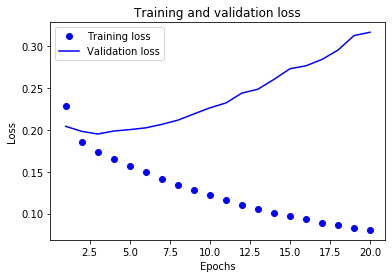

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

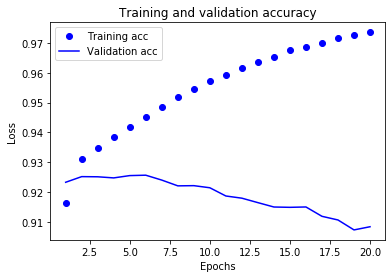

In [ ]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

##### Overfitting occured from the third round of Epoch.